# Training AlexNet on GTSRB dataset

We built the [AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) model based on [this](https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98) tutorial (code available [here](https://github.com/RichmondAlake/tensorflow_2_tutorials/blob/master/015_alexnet.ipynb)).

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
from datetime import datetime

In [ ]:
# comment out those two lines if not using Google Colab with Google Drive
from google.colab import drive
drive.mount('/content/drive')

save_path = f'/content/drive/MyDrive/Studium/Master/1. Semester/Machine Learning/ex3/GTSRB/AlexNet/{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}/'
#save_path = f'./GTSRB/AlexNet/{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}/' use this when running locally

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

In [ ]:
!git clone https://github.com/Sejmou/ml-ex3.git

fatal: destination path 'ml-ex3' already exists and is not an empty directory.


In [ ]:
!ls

data  drive  ml-ex3  sample_data


In [ ]:
import sys
sys.path.append('./ml-ex3/')# make script files in ml-ex3 accessible

In [ ]:
from data_loaders import GTSRBLoader

In [ ]:
IMG_WIDTH = IMG_HEIGHT = 257 # AlexNet expects images of size 257 x 257 as input

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = GTSRBLoader('./data').get_processed_imgs(target_width = 32, target_height = 32)# cannot resize to 257 directly, our implementation is too RAM-hungry

GTSRB dataset already downloaded, loading files from memory
loading training images and labels
loading test images and labels
done
processing training images
processing test images
done processing, creating train/val/test split


In [ ]:
def resize_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    return image, label

In [ ]:
NUM_CLASSES = len(np.unique(y_test))

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
validation_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

import gc
# make sure we get rid of all unused memory; we need every little piece of RAM!
del X_train
del y_train
del X_test
del y_test
del X_val
del y_val
gc.collect()

0

In [ ]:
train_ds_size = len(list(train_ds))
train_ds_size = len(list(test_ds))
validation_ds_size = len(list(validation_ds))

In [ ]:
train_ds = (train_ds
                  .map(resize_images)
                  #.shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=8, drop_remainder=True))

test_ds = (test_ds
                  .map(resize_images)
                  #.shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=8, drop_remainder=True))

validation_ds = (validation_ds
                  .map(resize_images)
                  #.shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=8, drop_remainder=True))

## Defining The Model

In [ ]:
def create_AlexNet():
  return keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

In [ ]:
model = create_AlexNet()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 62, 62, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### Callbacks (for looking at results, storing checkpoints (weights of model across epochs), fit time)

In [ ]:
root_logdir = save_path + 'tensor_board'

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [ ]:
checkpoint_path = save_path + "checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
time_path = save_path + 'fit_times.csv'

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
      epoch_fit_time = time.time() - self.epoch_time_start
      with open(time_path, 'a') as f:
        f.write(f'{batch},{epoch_fit_time}\n')
      self.times.append(epoch_fit_time)

time_cb = TimeHistory()

In [ ]:
model.fit(train_ds,
          epochs=50,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb, checkpoint_cb, time_cb])

Epoch 1/50
3430/3430 [==============================] - ETA: 0s - loss: 1.6835 - accuracy: 0.5517
Epoch 1: saving model to /content/drive/MyDrive/Studium/Master/1. Semester/Machine Learning/ex3/GTSRB/AlexNet/18/02/2022 11:59:51checkpoints/cp-0001.ckpt
3430/3430 [==============================] - 205s 59ms/step - loss: 1.6835 - accuracy: 0.5517 - val_loss: 0.3816 - val_accuracy: 0.8973
Epoch 2/50
3430/3430 [==============================] - ETA: 0s - loss: 0.4033 - accuracy: 0.8735
Epoch 2: saving model to /content/drive/MyDrive/Studium/Master/1. Semester/Machine Learning/ex3/GTSRB/AlexNet/18/02/2022 11:59:51checkpoints/cp-0002.ckpt
3430/3430 [==============================] - 203s 59ms/step - loss: 0.4033 - accuracy: 0.8735 - val_loss: 0.1045 - val_accuracy: 0.9730
Epoch 3/50
3430/3430 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.9485
Epoch 3: saving model to /content/drive/MyDrive/Studium/Master/1. Semester/Machine Learning/ex3/GTSRB/AlexNet/18/02/2022 11:59

KeyboardInterrupt: ignored

Note: The fit was cancelled after 10 epochs already. Still, model checkpoints were stored in the checkpoints folder (we defined and provided a callback for this purpose, see code above). Those checkpoints contain the weights for each epoch. We can recreate (compile) the model at any time (have to use exact same layers and layer parameters!) and load the weights for the epoch with best validation set accuracy.

## Evaluation on test data

In [ ]:
model.evaluate(test_ds)

1578/1578 [==============================] - 25s 16ms/step - loss: 0.1543 - accuracy: 0.9569


[0.1542670875787735, 0.9569074511528015]

Wow, an accuracy of more than 95%?! Let's look at the results in detail:

In [ ]:
y_preds = model.predict(test_ds)# matrix; row: observation, col: prob. for class
y_pred = np.argmax(y_preds, axis=1)

In [ ]:
y_pred.shape

(12624,)

In [ ]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
y_test.shape

(12624,)

In [ ]:
print('Test Data accuracy(%): ', accuracy_score(y_test, y_pred)*100)

Test Data accuracy(%):  95.69074778200253


In [ ]:
cf = confusion_matrix(y_test, y_pred)

In [ ]:
# mapping of numeric label to text label
text_labels = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

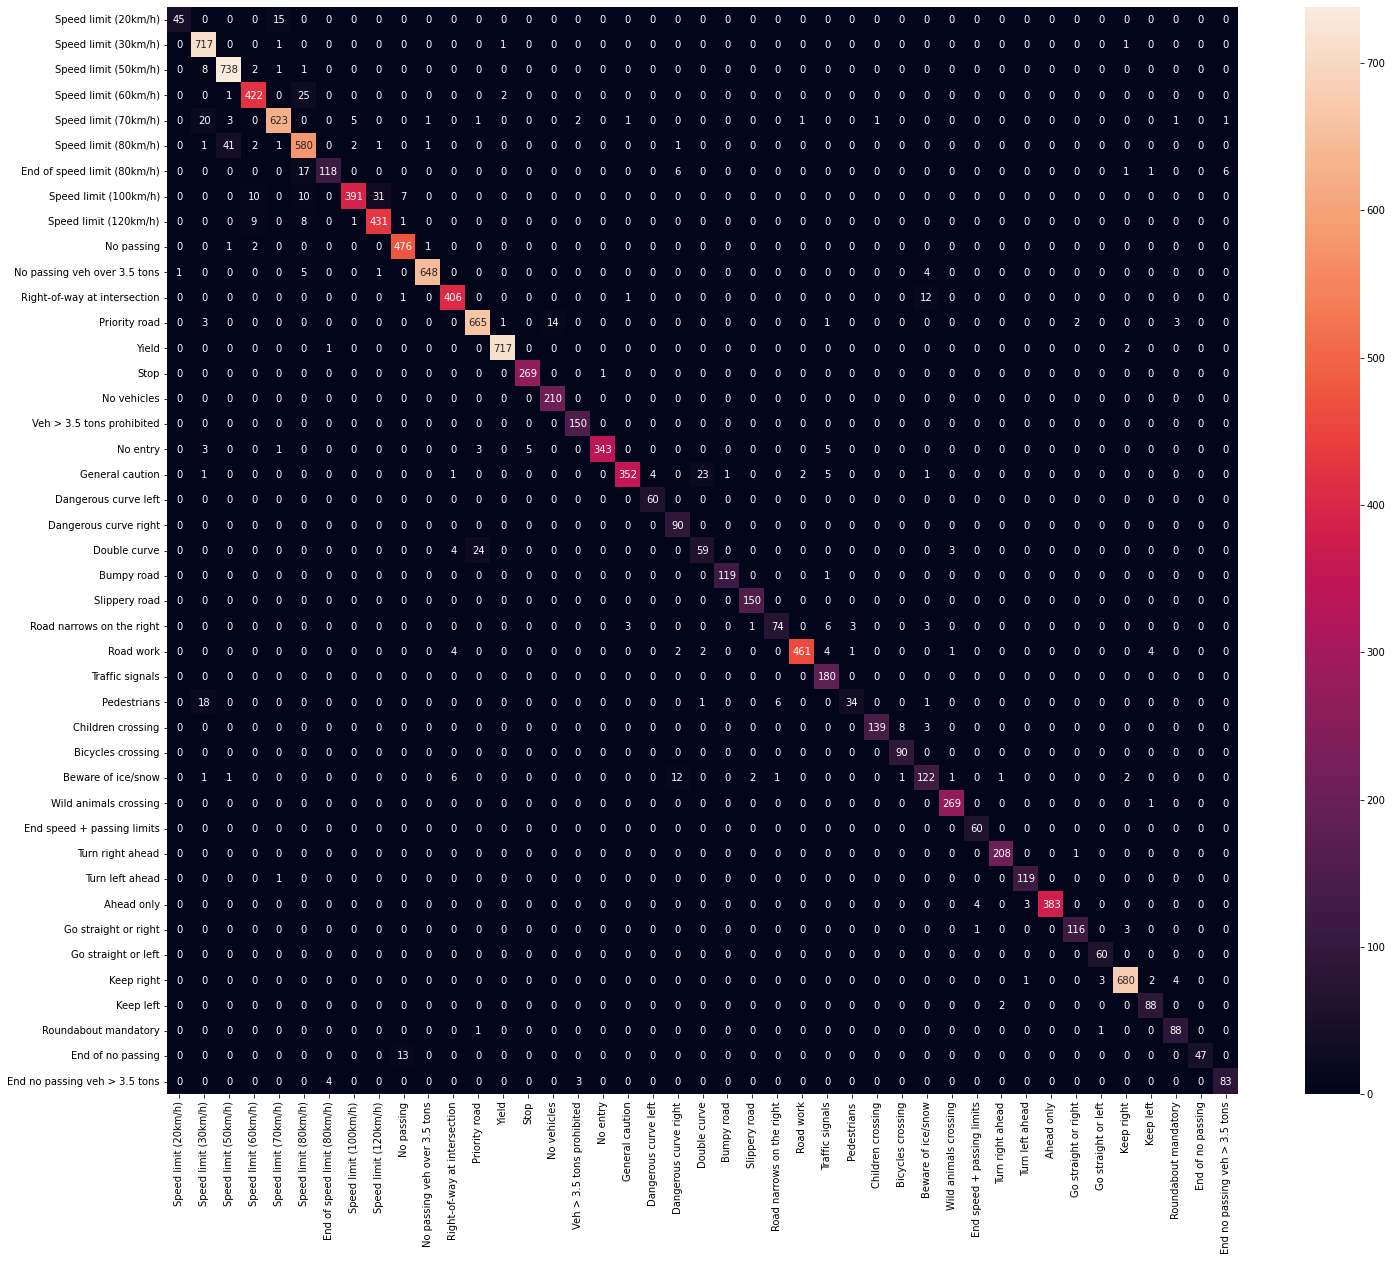

In [ ]:
keys, values = zip(*text_labels.items())
df_cm = pd.DataFrame(cf, index = values,  columns = values)
plt.figure(figsize = (24,20))
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
print(classification_report(y_test, y_pred, labels=keys, target_names=values))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.98      0.75      0.85        60
         Speed limit (30km/h)       0.93      1.00      0.96       720
         Speed limit (50km/h)       0.94      0.98      0.96       750
         Speed limit (60km/h)       0.94      0.94      0.94       450
         Speed limit (70km/h)       0.97      0.94      0.96       660
         Speed limit (80km/h)       0.90      0.92      0.91       630
  End of speed limit (80km/h)       0.96      0.79      0.87       149
        Speed limit (100km/h)       0.98      0.87      0.92       449
        Speed limit (120km/h)       0.93      0.96      0.94       450
                   No passing       0.96      0.99      0.97       480
 No passing veh over 3.5 tons       1.00      0.98      0.99       659
 Right-of-way at intersection       0.96      0.97      0.97       420
                Priority road       0.96      0.97      0.96       689
     